In [72]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import argparse
import csv
import os
import json
import sys
import pickle
import numpy as np
import pandas as pd
from os.path import join


- What's the fewest number of levels for the agent to close the generalization gap??
- Does training for longer help?

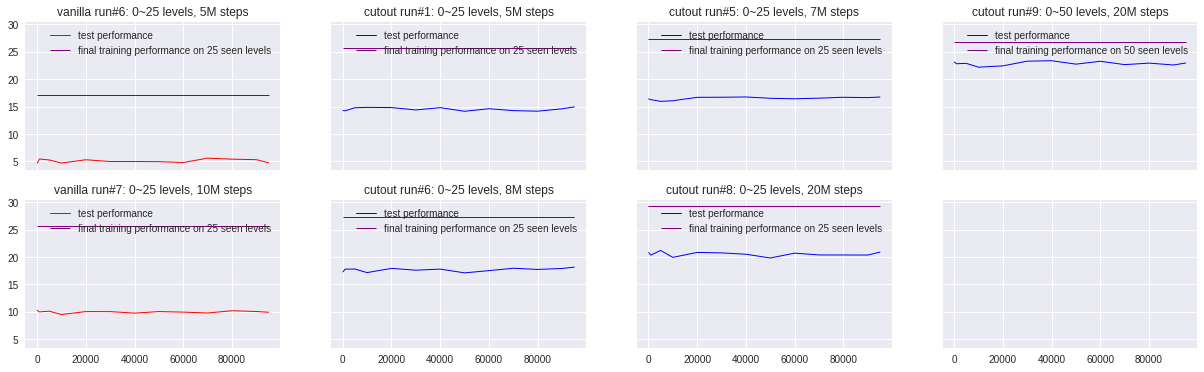

In [95]:
agents = ["vanilla"]*2 + ["cutout"]*5
ids = [6,7]+ [1,6,5,8,9]
plot_gen_gap(agents, ids)

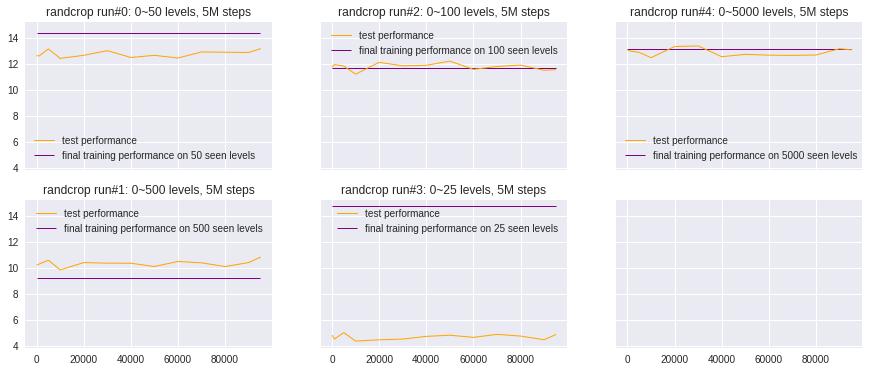

In [102]:
agents = ["randcrop"]*5
ids = range(5)
plot_gen_gap(agents, ids)

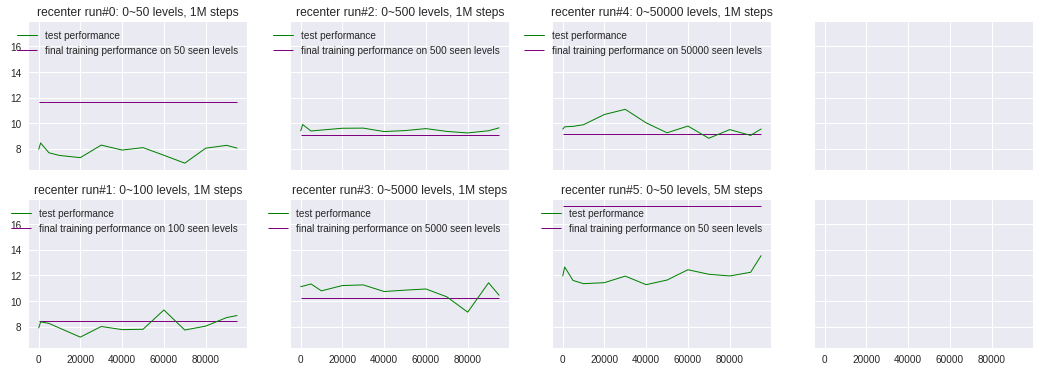

In [97]:
agents = ["recenter"]*6
ids = range(6)
plot_gen_gap(agents, ids)

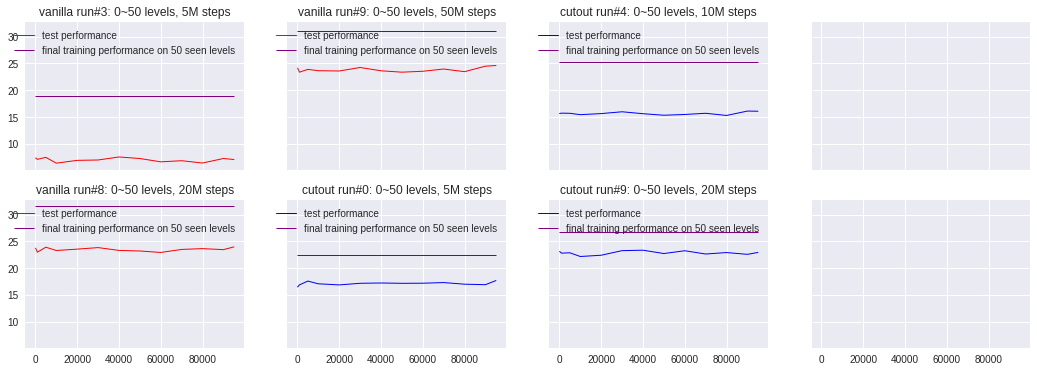

In [96]:
agents = ["vanilla"]*3 + ["cutout"]*3
ids = [3,8,9]+[0,4,9]
plot_gen_gap(agents, ids)

In [101]:
TEST = [100, 1000, 5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 95000]
COLORS = {"vanilla": "red", "cutout":"blue", "recenter":"green", "randcrop":"orange"}
def plot_gen_gap(agents, run_ids):
    n = len(agents)
    fig, axs = plt.subplots(2, n//2+1, figsize=(3*n, 3*2), sharex=True, sharey=True)
    ## read data
    for agent, load_id, idx in zip(agents, run_ids, range(n)):
        jpath = join("log", agent, "train", "args_run_{}.json".format(str(load_id).zfill(2)))
        with open(jpath, 'r') as jfile:
            arg = json.load(jfile)
        avg, stds = [], []
        for i in range(13):
            test_p = join("log", agent, "test", "run_{}_load{}".format(\
                            str(i).zfill(2), str(load_id)) )
            test_j = join(test_p, "args_run_{}_load{}.json".format(\
                            str(i).zfill(2), str(load_id)))
            with open(test_j, 'r') as test_jfile:
                test_arg = json.load(test_jfile)
            p = join(test_p, "progress.csv")
            df = pd.read_csv(p)
            rew = df["eprew100"].to_numpy()[1:]
            avg.append(np.mean(rew))
            stds.append(np.std(rew))
        #plot test
        ax = axs[idx%2, idx//2]

        ax.plot(TEST, avg, label="test performance", color=COLORS[agent], lw=1)
        
        ## read and plot training 
        prog_ = join("log", agent, "train", "run_"+str(load_id).zfill(2), 'progress.csv') 
        df = pd.read_csv(prog_)
        #x = df['misc/total_timesteps'].to_numpy()
        if agent == "vanilla":
            y = df['eprewmean'].to_numpy() ## baselines ppo code is slightly different
        else:
            y = df['eprew100'].to_numpy()
        train_mean = np.mean(y[-5:-1])
        
        ax.hlines(train_mean, xmin=0, xmax=95000,lw=1,color="purple",
                  label="final training performance on {} seen levels".format(str(arg["num_levels"])))
        
        
        title = "{} run#{}: 0~{} levels, {}M steps".format(\
             agent, arg["run_id"], str(arg["num_levels"]), str(arg["total_tsteps"] // int(1e6)))
        ax.set_title(title)
        ax.legend(loc="best")
    plt.show()